In [1]:
%run ./reports_config.py

In [23]:
from report import draw_score_heatmap, draw_score_parallel_coord, draw_score_stripplot, prepare_results, render_summary
from report.config import *
from report.util import create_file, display

# Comparisons

## Compare custom runs

Here comparing results for one fold

In [36]:
import glob

constraint_1h = "1h8c"
constraint_4h = "4h8c"
constraint_8h = "8h8c"
results_dir = "../my_results/h2opaper"
results_group = ""

runs = dict(
    ref_1h=dict(
        ref=True,
        framework='all',
        renamings=renamed_frameworks,
        results_files=glob.glob(f"input/results_*8c1h_ref.csv")
    ),
    ref_4h=dict(
        ref=True,
        framework='all',
        renamings=renamed_frameworks,
        results_files=glob.glob(f"input/results_*8c4h_ref.csv")
    ),
    h2o_1h=dict(
        framework='H2OAutoML',
        results_files=glob.glob(f"{results_dir}/h2oautoml*{constraint_1h}*/scores/results.csv")
    ),
    h2o_4h=dict(
        framework='H2OAutoML',
        results_files=list(set(glob.glob(f"{results_dir}/h2oautoml*{constraint_4h}*/scores/results.csv")) - set(glob.glob(f"{results_dir}/h2oautoml*_large_{constraint_4h}*/scores/results.csv")))
    ),
    autosklearn_1h=dict(
        framework='autosklearn',
        results_files=glob.glob(f"{results_dir}/autosklearn*{constraint_1h}*/scores/results.csv")
    ),
    autosklearn_4h=dict(
        framework='autosklearn',
        results_files=glob.glob(f"{results_dir}/autosklearn*{constraint_4h}*/scores/results.csv")
    ),
    tpot_1h=dict(
        framework='TPOT',
        results_files=glob.glob(f"{results_dir}/tpot*{constraint_1h}*/scores/results.csv")
    ),
    tpot_4h=dict(
        framework='TPOT',
        results_files=glob.glob(f"{results_dir}/tpot*{constraint_4h}*/scores/results.csv")
    ),
)
runs

{'ref_1h': {'framework': 'RandomForest',
  'results_files': ['input/results_medium-8c1h_ref.csv',
   'input/results_small-8c1h_ref.csv']},
 'ref_4h': {'framework': 'RandomForest',
  'results_files': ['input/results_small-8c4h_ref.csv',
   'input/results_large-8c4h_ref.csv',
   'input/results_medium-8c4h_ref.csv']},
 'h2o_1h': {'framework': 'H2OAutoML',
  'results_files': ['../my_results/h2opaper/h2oautoml_medium_1h8c_aws_20200410T051845/scores/results.csv',
   '../my_results/h2opaper/h2oautoml_small_1h8c_aws_20200410T000452/scores/results.csv']},
 'h2o_4h': {'ref': True,
  'framework': 'H2OAutoML',
  'results_files': ['../my_results/h2opaper/h2oautoml_small_4h8c_aws_20200409T230430/scores/results.csv',
   '../my_results/h2opaper/h2oautoml_medium_4h8c_aws_20200410T091002/scores/results.csv']},
 'autosklearn_1h': {'framework': 'autosklearn',
  'results_files': ['../my_results/h2opaper/autosklearn_small_1h8c_aws_20200406T222946/scores/results.csv',
   '../my_results/h2opaper/autosklearn_m

In [37]:
runs_results = {name: prepare_results(run['results_files'], 
                                      renamings={run['framework']: name}) 
                for name, run in runs.items()}

In [33]:
ref_results = next(res for name, res in runs_results.items() if runs[name].get('ref', False))

In [34]:
import pandas as pd

def apply_filter(res, filtr):
    r = res.results
    return r.loc[filtr(r, )]

all_res = pd.concat([apply_filter(res, lambda r: (r.framework==name)&(r.fold==0)) for name, res in runs_results.items()])

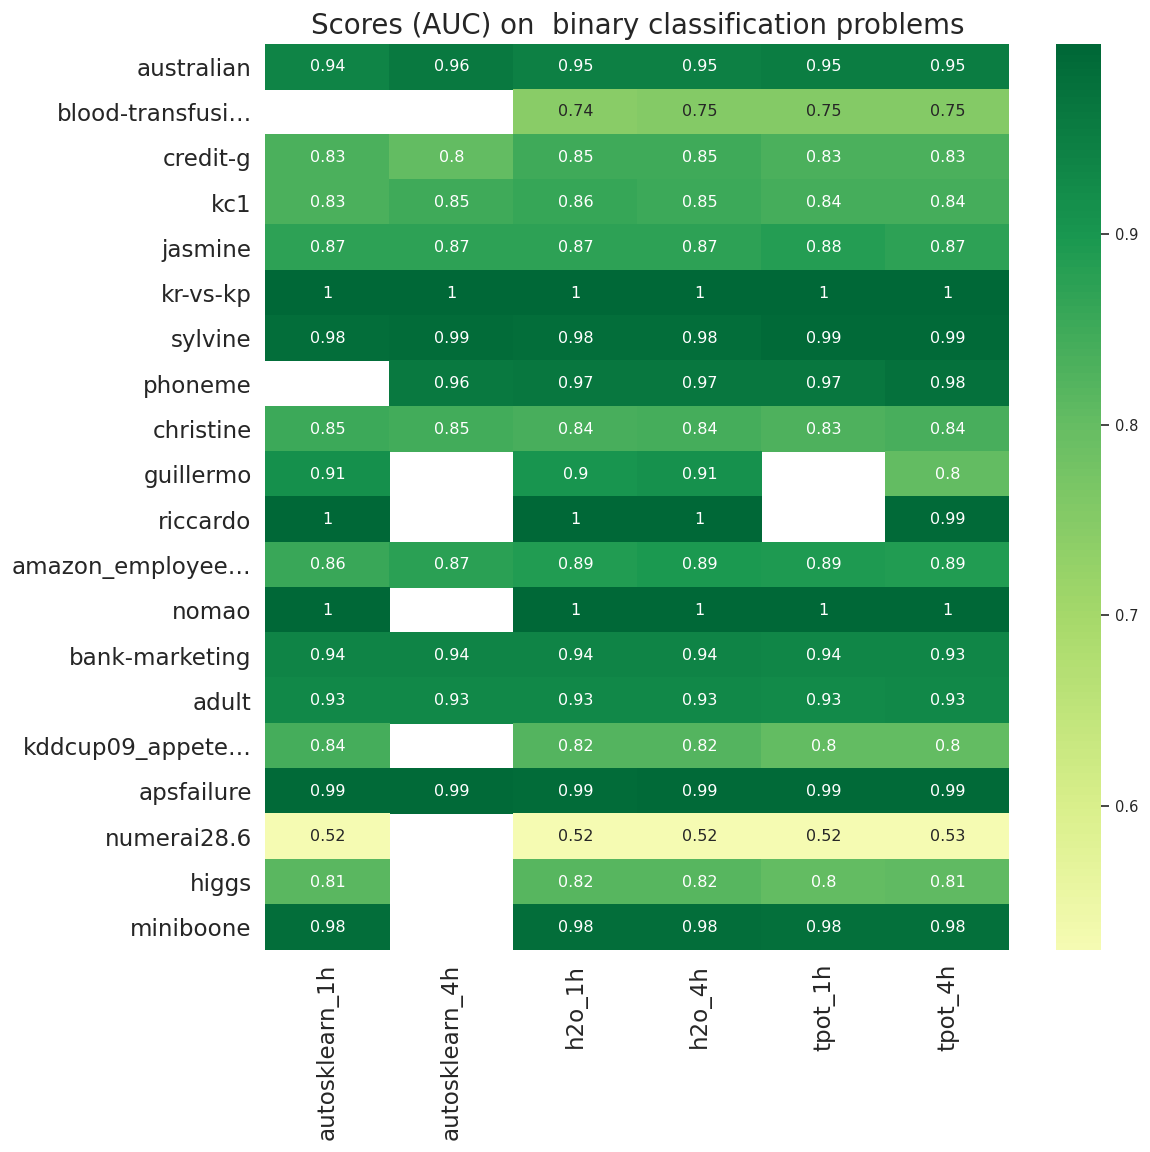

In [35]:
draw_score_heatmap('score',
                   results=all_res,
                   type_filter='binary', 
                   metadata=ref_results.metadata,
                   y_sort_by=tasks_sort_by,
                   title=f"Scores ({binary_score_label}) on {results_group} binary classification problems",
                   center=0.5);

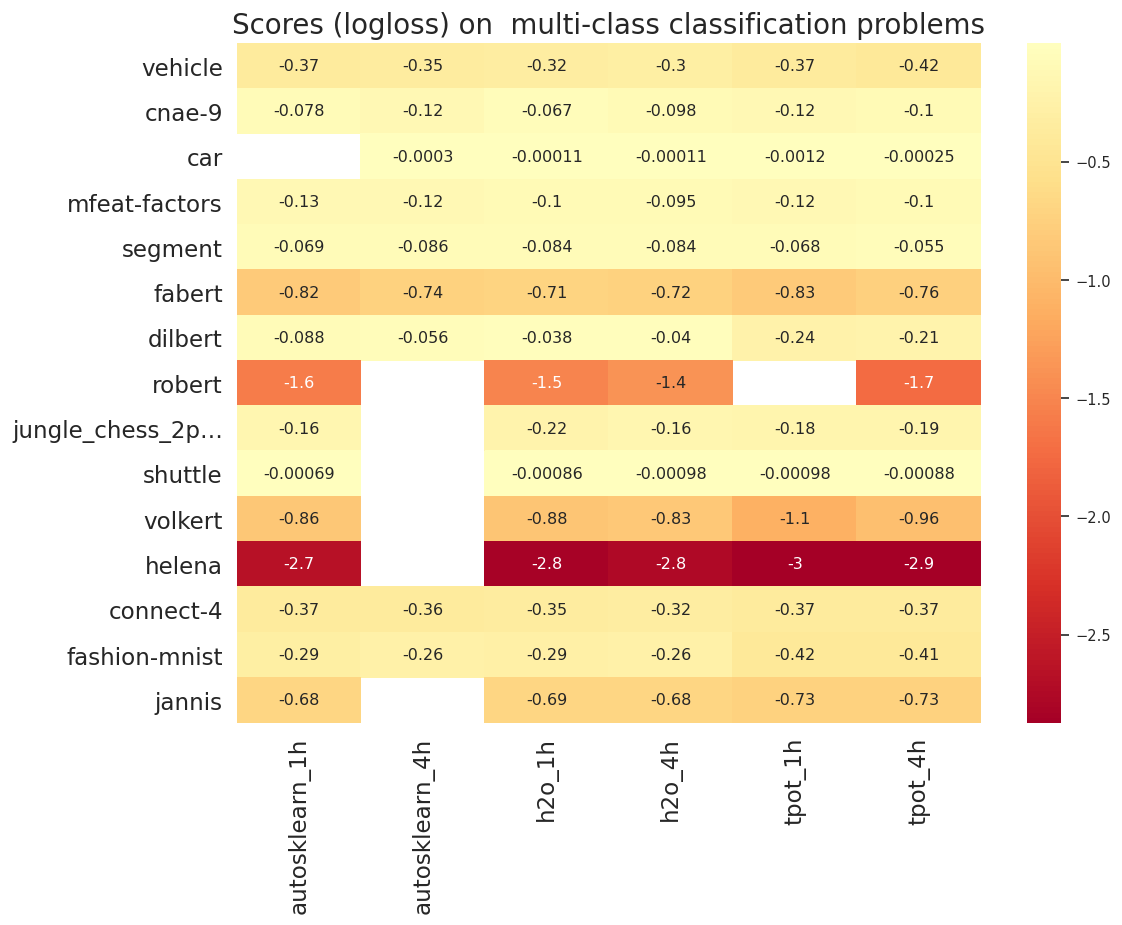

In [19]:
draw_score_heatmap('score', 
                   results=all_res,
                   type_filter='multiclass', 
                   metadata=ref_results.metadata,
                   y_sort_by=tasks_sort_by,
                   title=f"Scores ({multiclass_score_label}) on {results_group} multi-class classification problems",
                   center=0);

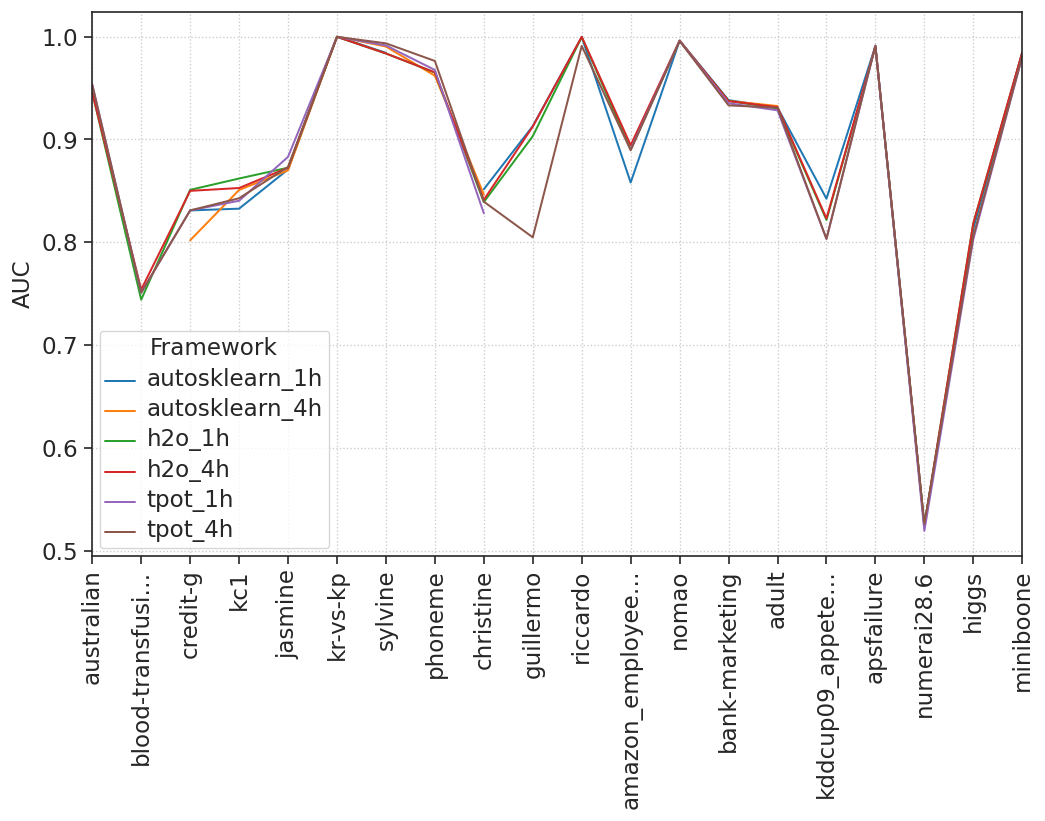

In [20]:
draw_score_parallel_coord('score',
                          results=all_res,
                          type_filter='binary', 
                          metadata=ref_results.metadata,
                          x_sort_by=tasks_sort_by,
                          ylabel=binary_score_label,
                          legend_loc='lower left',
                         );

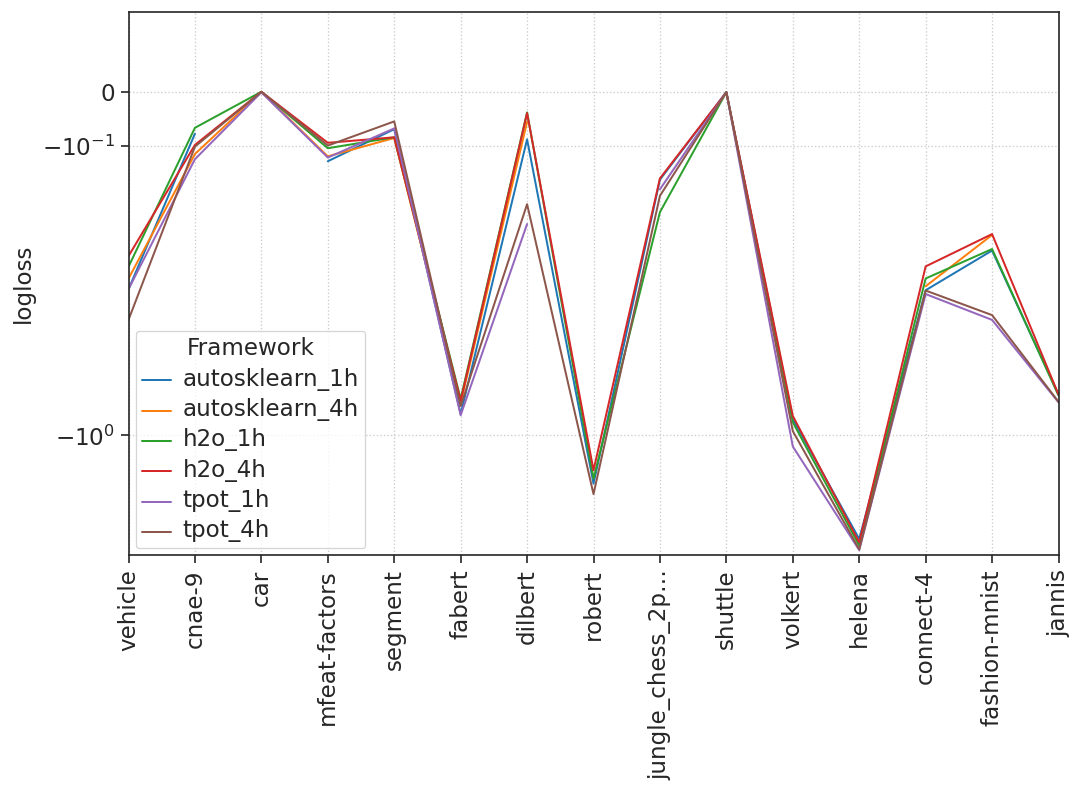

In [21]:
draw_score_parallel_coord('score',
                          results=all_res,
                          type_filter='multiclass', 
                          metadata=ref_results.metadata,
                          x_sort_by=tasks_sort_by,
                          ylabel=multiclass_score_label,
                          yscale=('symlog', dict(linthreshy=0.5)),
                          legend_loc='lower left',
                         );

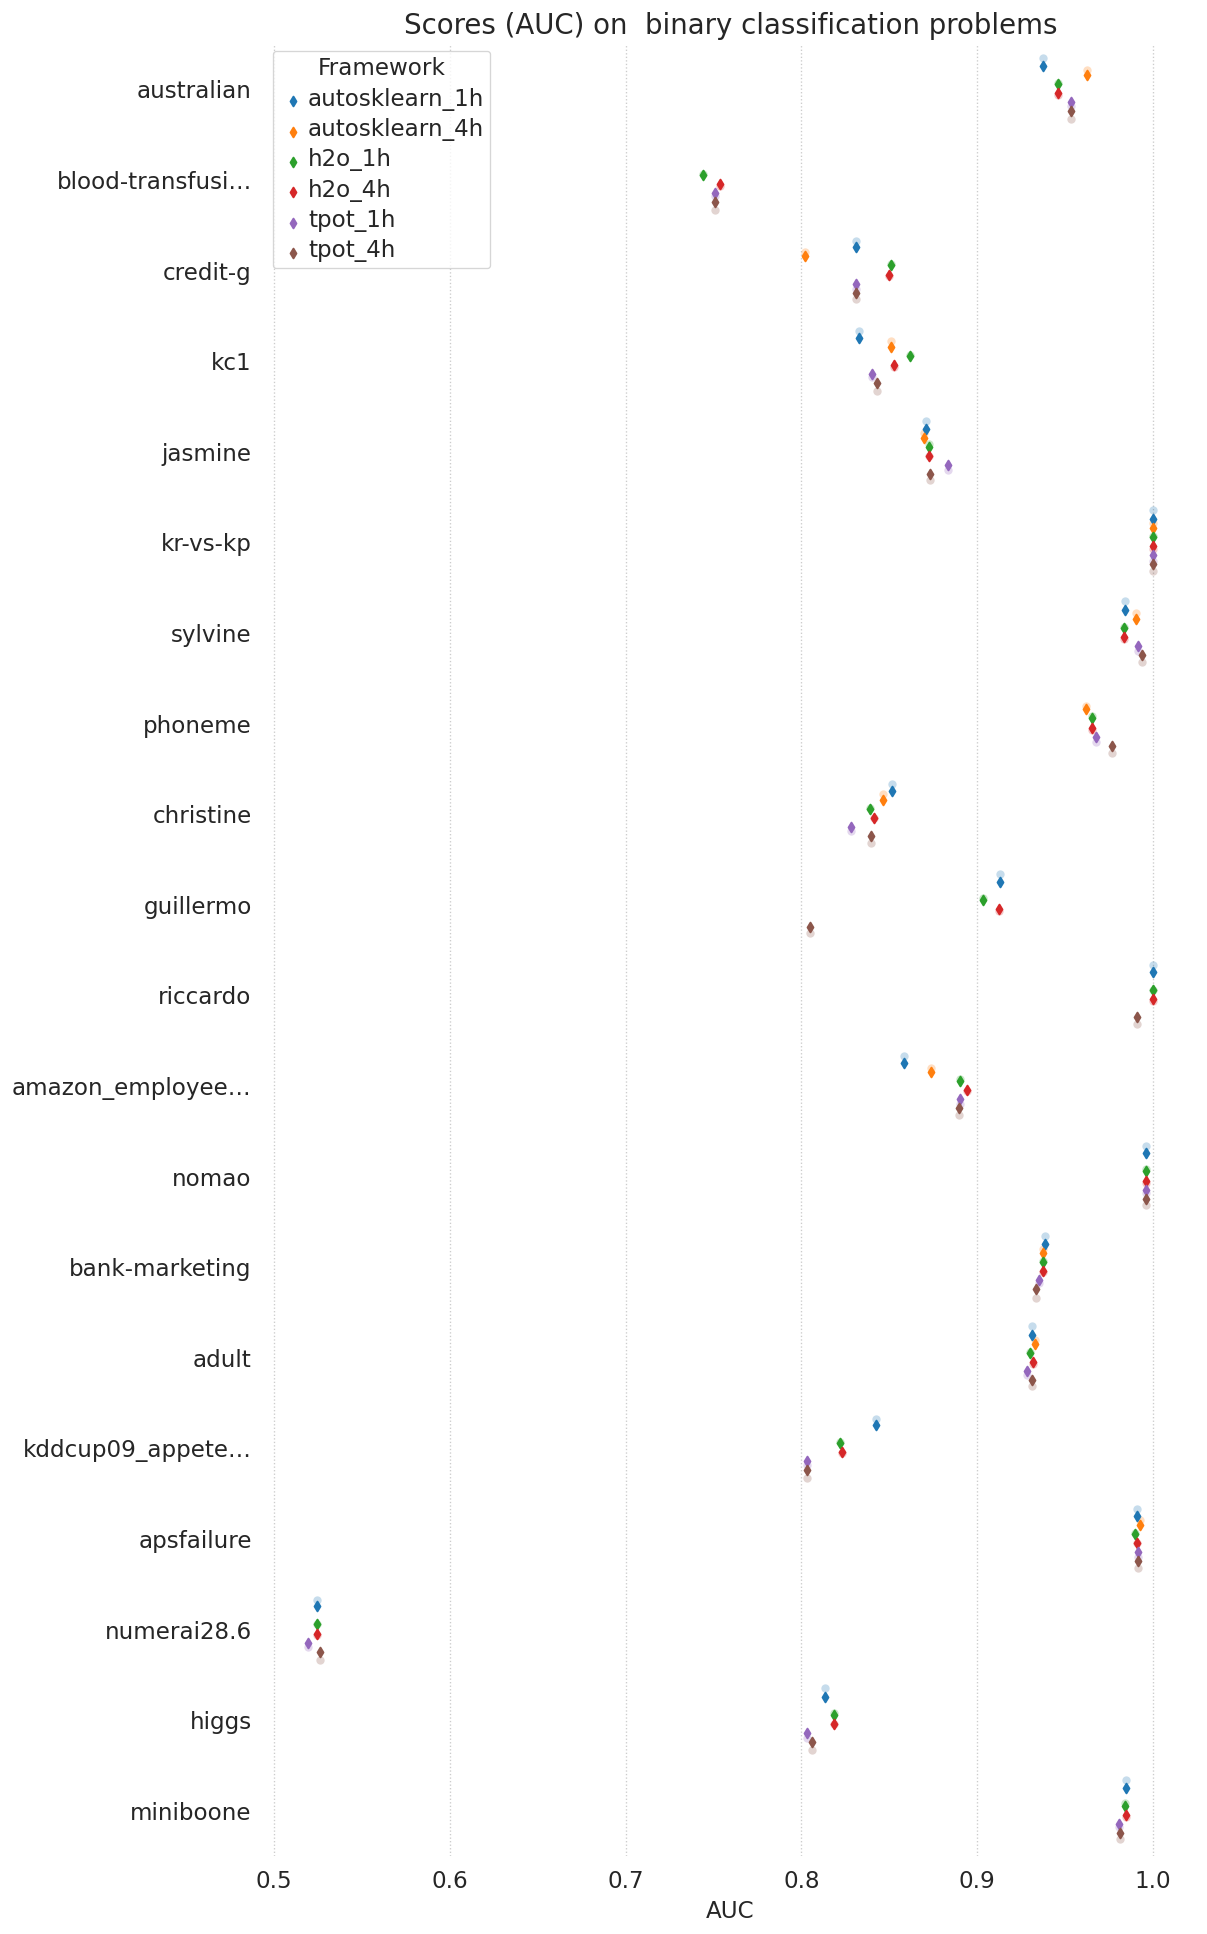

In [29]:
draw_score_stripplot('score', 
                     results=all_res.sort_values(by=['framework']),
                     type_filter='binary', 
                     metadata=ref_results.metadata,
                     y_sort_by=tasks_sort_by,
                     title=f"Scores ({binary_score_label}) on {results_group} binary classification problems",
                     xlabel=binary_score_label
                    );

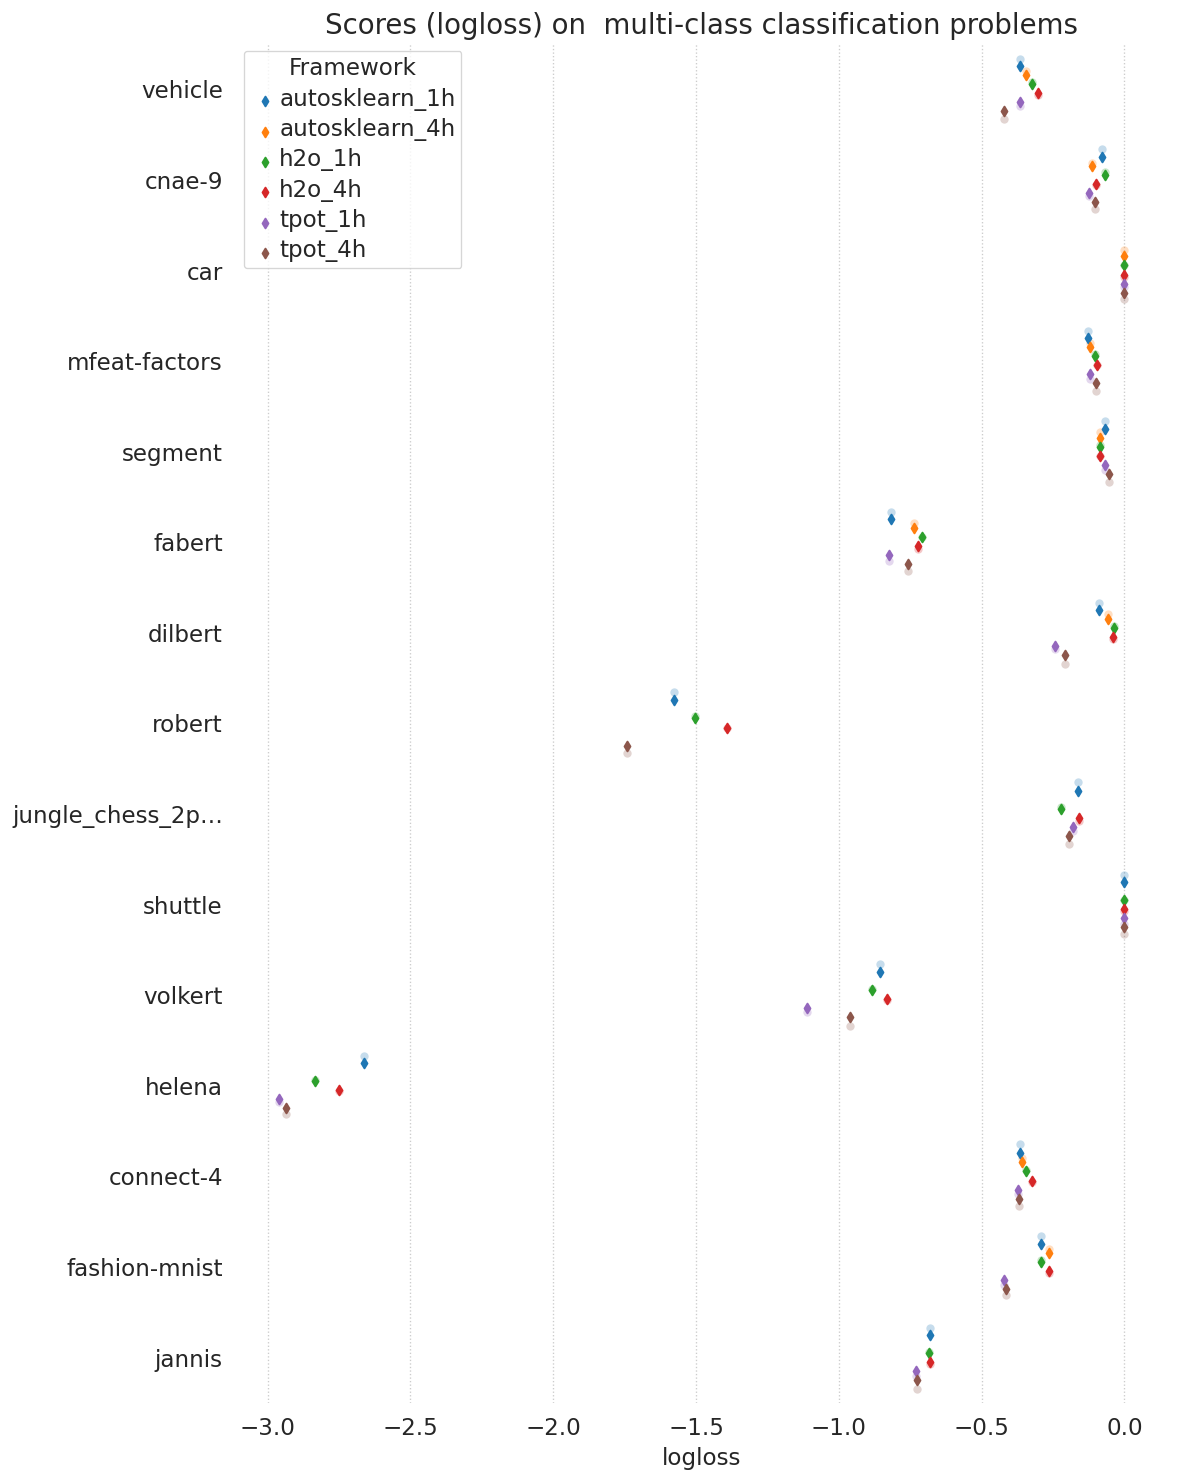

In [30]:
draw_score_stripplot('score', 
                     results=all_res.sort_values(by=['framework']),
                     type_filter='multiclass', 
                     metadata=ref_results.metadata,
                     y_sort_by=tasks_sort_by,
                     title=f"Scores ({multiclass_score_label}) on {results_group} multi-class classification problems",
                     xlabel=multiclass_score_label
                    );

In [22]:
render_summary('result', 
               results=all_res)

In [ ]:
render_summary('models', 
               results=all_res)